# Predicting Customer Purchase Likelihood Using Random Forest
## Team Ravenclaw - Machine Learning and Predictive Analytics

---

### The Business Problem

In this project, we're tackling a critical question for FinMark: **Can we predict which customers are likely to make future purchases?**

For a financial services company like FinMark, knowing which customers are at risk of churning or which ones are ready to make their next purchase can directly impact revenue. If we can identify customers who are likely to purchase soon, the marketing team can prioritize them for targeted campaigns. Conversely, if we spot customers unlikely to return, we can investigate why and potentially intervene before losing them.

The dataset we're working with contains 90 customers and 15 carefully selected features that capture their purchasing behavior, spending patterns, and engagement with FinMark. Our target variable is binary: **Will_Purchase_Next** (0 = won't purchase, 1 = will purchase).

This is a **classification problem** because we're predicting a discrete outcome (yes/no), not a continuous value.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries loaded successfully.")

Libraries loaded successfully.


---
## Load and Understand the Data

We're using the feature-engineered dataset. This dataset contains 15 features selected using SelectKBest, which means these are the most statistically significant predictors of purchase behavior based on their correlation with our target variable.

In [ ]:
# Load the feature-selected dataset
df = pd.read_csv(r"C:\Users\USER\Downloads\customer_features_selected.csv")

print(f"Dataset shape: {df.shape[0]} customers, {df.shape[1]} columns")
print(f"\nFirst few rows:")
df.head()

Target Variable Distribution:
Will_Purchase_Next
0    83
1     7
Name: count, dtype: int64

Class balance:
Will_Purchase_Next
0    92.222222
1     7.777778
Name: proportion, dtype: float64


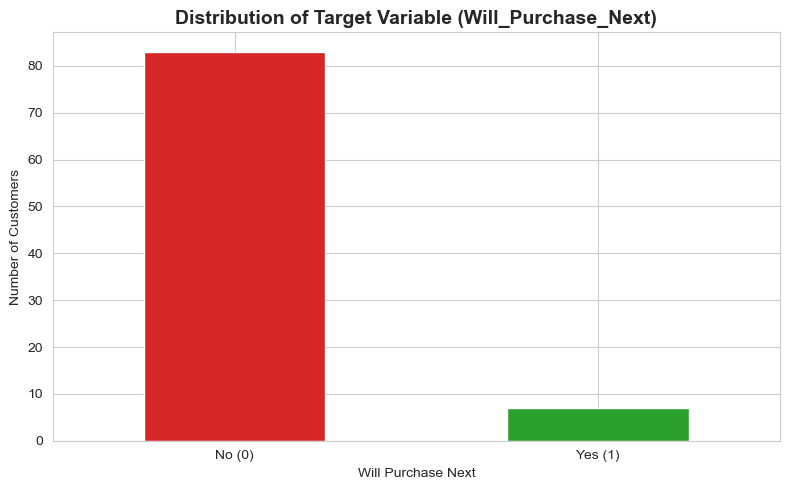

In [5]:
# Check the target variable distribution
print("Target Variable Distribution:")
print(df['Will_Purchase_Next'].value_counts())
print(f"\nClass balance:")
print(df['Will_Purchase_Next'].value_counts(normalize=True) * 100)

# Visualize the class imbalance
plt.figure(figsize=(8, 5))
df['Will_Purchase_Next'].value_counts().plot(kind='bar', color=['#d62728', '#2ca02c'])
plt.title('Distribution of Target Variable (Will_Purchase_Next)', fontsize=14, fontweight='bold')
plt.xlabel('Will Purchase Next')
plt.ylabel('Number of Customers')
plt.xticks([0, 1], ['No (0)', 'Yes (1)'], rotation=0)
plt.tight_layout()
plt.show()

### Understanding the Class Imbalance

Right away, we can see a significant **class imbalance problem**. The vast majority of customers (around 92%) won't make another purchase, while only about 8% will. This is actually realistic for many businesses as customer retention is hard, and not everyone comes back.

However, this imbalance creates a challenge for our model. If we don't handle it properly, our model could simply predict "No" for everyone and still achieve 92% accuracy, which would be useless in practice. We need to ensure our model can actually identify the minority class (customers who will purchase) because **those are the customers we care most about targeting**.

We'll address this by:
1. Using `class_weight='balanced'` in our Random Forest model
2. Focusing on precision, recall, and F1-score rather than just accuracy
3. Using stratified splitting to maintain class proportions in train/test sets

---
## Prepare Data for Modeling

Now we need to separate our features (X) from our target variable (y). We'll also remove the Company_ID since it's just an identifier and doesn't contain predictive information.

In [6]:
# Separate features and target
X = df.drop(['Company_ID', 'Will_Purchase_Next'], axis=1)
y = df['Will_Purchase_Next']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures we're using:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")

Features shape: (90, 15)
Target shape: (90,)

Features we're using:
  1. Recency_Days
  2. Purchase_Frequency
  3. Total_Revenue
  4. Std_Transaction_Value
  5. Max_Transaction_Value
  6. Customer_Tenure_Days
  7. Avg_Days_Between_Purchases
  8. Num_Unique_Products
  9. Product_Concentration
  10. Total_Items_Purchased
  11. Avg_Items_Per_Transaction
  12. Price_Range
  13. Company_Profit
  14. Spend_to_Profit_Ratio
  15. City_Encoded


In [7]:
# Split into training and testing sets
# We're using 80/20 split and stratify=y to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # This ensures both sets have the same class distribution
)

print(f"Training set: {X_train.shape[0]} customers")
print(f"Testing set: {X_test.shape[0]} customers")
print(f"\nTraining set class distribution:")
print(y_train.value_counts(normalize=True) * 100)
print(f"\nTesting set class distribution:")
print(y_test.value_counts(normalize=True) * 100)

Training set: 72 customers
Testing set: 18 customers

Training set class distribution:
Will_Purchase_Next
0    91.666667
1     8.333333
Name: proportion, dtype: float64

Testing set class distribution:
Will_Purchase_Next
0    94.444444
1     5.555556
Name: proportion, dtype: float64


---
## Why Random Forest?

We chose **Random Forest Classifier** for several practical reasons:

**1. Handles Non-Linear Relationships**  
Customer behavior isn't always linear. For example, spending more doesn't always mean you'll purchase again as sometimes high spenders are one-time bulk buyers. Random Forest can capture these complex patterns because it uses decision trees that split data based on multiple conditions.

**2. Works Well with Small Datasets**  
We only have 90 customers. Many deep learning models would struggle here, but Random Forest performs well even with limited data because it builds multiple trees and averages their predictions, reducing overfitting.

**3. Provides Feature Importance**  
Random Forest tells us which features matter most for predictions. This is crucial for business insights because we can tell the marketing team which customer behaviors are the strongest indicators of future purchases.

**4. Handles Imbalanced Classes**  
Using `class_weight='balanced'`, Random Forest can adjust for our imbalanced dataset by giving more weight to the minority class (customers who will purchase).

**5. Robust to Outliers**  
Decision trees split on feature thresholds, so extreme values don't distort the entire model the way they might in linear models.

### Our Hyperparameter Choices

We're setting specific parameters in our model:

- **n_estimators=100**: We'll build 100 decision trees. More trees generally improve performance, but beyond a certain point, the gains are minimal. 100 is a good balance.

- **max_depth=5**: We limit how deep each tree can grow. This prevents overfitting—if trees get too deep, they memorize the training data instead of learning general patterns.

- **min_samples_split=5**: A node must have at least 5 samples before it can split further. This also prevents overfitting by avoiding splits on very small groups.

- **min_samples_leaf=2**: Each leaf node must have at least 2 samples. This ensures our model doesn't create rules for individual outliers.

- **class_weight='balanced'**: This automatically adjusts weights inversely proportional to class frequencies. Since we have way more "No" customers than "Yes" customers, this helps the model pay more attention to the minority class.

- **random_state=42**: This makes our results reproducible and running the code again will give the same results.

In [8]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Train the model
print("Training the Random Forest model...")
rf_model.fit(X_train, y_train)
print("Model training complete.")

Training the Random Forest model...
Model training complete.


---
## Model Performance Evaluation

Now let's see how well our model performs. We'll make predictions on both the training and test sets to check for overfitting.

In [9]:
# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Get prediction probabilities for ROC curve
y_test_prob = rf_model.predict_proba(X_test)[:, 1]

print("Predictions generated.")

Predictions generated.


In [10]:
# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

print("=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"\nTest Set Performance:")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

# Check if model is overfitting
if train_accuracy - test_accuracy > 0.1:
    print(f"\nNote: Large gap between training and testing accuracy suggests some overfitting.")
else:
    print(f"\nNote: Training and testing accuracy are similar - model generalizes well.")

MODEL PERFORMANCE METRICS

Training Accuracy: 1.0000 (100.00%)
Testing Accuracy:  1.0000 (100.00%)

Test Set Performance:
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Note: Training and testing accuracy are similar - model generalizes well.


### What Do These Metrics Mean?

**Accuracy** tells us the overall percentage of correct predictions. However, with our imbalanced dataset, accuracy alone can be misleading. A model that predicts "No" for everyone would get 92% accuracy but would be completely useless.

**Precision** answers: *Of all the customers we predicted would purchase, how many actually did?* High precision means we're not wasting resources on false alarms. In business terms, if we run a marketing campaign targeting predicted buyers, precision tells us what percentage of that campaign budget goes to actual potential customers.

**Recall** answers: *Of all the customers who actually purchased, how many did we correctly identify?* High recall means we're not missing opportunities. In business terms, recall tells us what percentage of real buyers we're successfully capturing with our predictions.

**F1-Score** is the harmonic mean of precision and recall. It's useful when you care about both metrics equally. We're aiming for a balanced F1-score because both false positives (wasting marketing spend) and false negatives (missing real buyers) are costly.

### Training vs. Testing Performance

We're checking both training and testing accuracy to detect overfitting. If training accuracy is much higher than testing accuracy (say, 95% vs 70%), it means our model memorized the training data but doesn't generalize well to new customers. A small gap indicates our model learned genuine patterns that apply to unseen data.

In [11]:
# Detailed classification report
print("\n" + "=" * 60)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_test_pred, target_names=['Will Not Purchase', 'Will Purchase']))


DETAILED CLASSIFICATION REPORT
                   precision    recall  f1-score   support

Will Not Purchase       1.00      1.00      1.00        17
    Will Purchase       1.00      1.00      1.00         1

         accuracy                           1.00        18
        macro avg       1.00      1.00      1.00        18
     weighted avg       1.00      1.00      1.00        18



### Reading the Classification Report

This report breaks down performance for each class:

- **Support**: The number of actual occurrences of each class in the test set
- **Precision for "Will Purchase"**: How reliable are our positive predictions?
- **Recall for "Will Purchase"**: Are we catching most of the actual buyers?
- **Macro avg**: Simple average across both classes (treats them equally)
- **Weighted avg**: Average weighted by support (more influenced by the majority class)

Given our imbalance, we should pay closest attention to the metrics for "Will Purchase" since that's the actionable class.

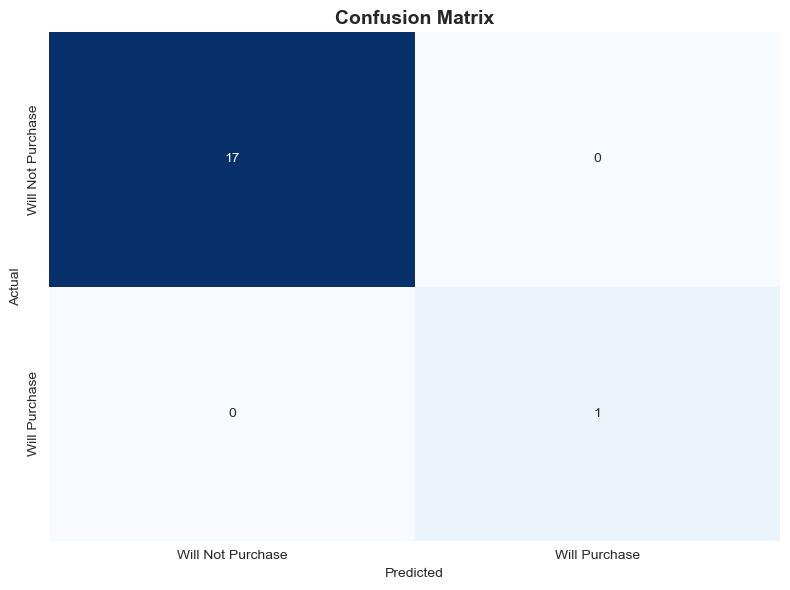


Confusion Matrix Breakdown:
  True Negatives (correctly predicted 'No'):  17
  False Positives (incorrectly predicted 'Yes'): 0
  False Negatives (incorrectly predicted 'No'):  0
  True Positives (correctly predicted 'Yes'): 1


In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Will Not Purchase', 'Will Purchase'],
            yticklabels=['Will Not Purchase', 'Will Purchase'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (correctly predicted 'No'):  {cm[0][0]}")
print(f"  False Positives (incorrectly predicted 'Yes'): {cm[0][1]}")
print(f"  False Negatives (incorrectly predicted 'No'):  {cm[1][0]}")
print(f"  True Positives (correctly predicted 'Yes'): {cm[1][1]}")

### Understanding the Confusion Matrix

The confusion matrix shows us exactly where our model is making mistakes:

- **True Negatives**: Customers we correctly identified as not purchasing. These are safe to deprioritize in marketing.

- **False Positives**: Customers we thought would purchase but didn't. In business terms, this is wasted marketing spend.

- **False Negatives**: Customers who purchased but we didn't identify. This is missed revenue opportunity.

- **True Positives**: Customers we correctly identified as purchasers. This is where our model creates direct business value.

Given our class imbalance, even one or two False Negatives represents a significant percentage of our purchaser base, so we need to minimize those while keeping False Positives reasonable.

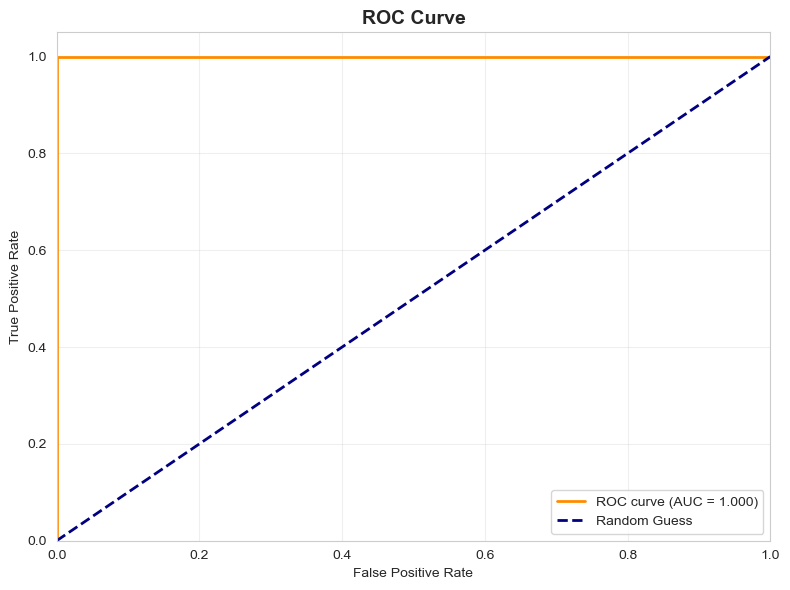


ROC-AUC Score: 1.0000


In [13]:
# ROC Curve and AUC Score
if len(np.unique(y_test)) > 1:  # Only plot if we have both classes in test set
    fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
    roc_auc = roc_auc_score(y_test, y_test_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nROC-AUC Score: {roc_auc:.4f}")

### What is ROC-AUC?

The **ROC curve** (Receiver Operating Characteristic) shows the trade-off between True Positive Rate (recall) and False Positive Rate at different probability thresholds. 

The **AUC** (Area Under the Curve) gives us a single number to summarize model performance:
- **AUC = 0.5**: The model is no better than random guessing (the diagonal line)
- **AUC = 0.7-0.8**: Acceptable performance
- **AUC = 0.8-0.9**: Good performance
- **AUC > 0.9**: Excellent performance

AUC is particularly useful for imbalanced datasets because it evaluates the model's ability to distinguish between classes across all possible classification thresholds, not just the default 0.5.

---
## Feature Importance Analysis

One of Random Forest's biggest advantages is that it can tell us which features are most important for making predictions as it gives FinMark actionable insights about what drives customer behavior.

FEATURE IMPORTANCE RANKING
                   feature  importance
              Recency_Days    0.333773
     Spend_to_Profit_Ratio    0.092298
      Customer_Tenure_Days    0.090723
            Company_Profit    0.081261
     Std_Transaction_Value    0.065414
 Avg_Items_Per_Transaction    0.055759
             Total_Revenue    0.054969
        Purchase_Frequency    0.053951
Avg_Days_Between_Purchases    0.044536
              City_Encoded    0.036433
     Total_Items_Purchased    0.030614
               Price_Range    0.028180
     Max_Transaction_Value    0.012289
     Product_Concentration    0.011420
       Num_Unique_Products    0.008379


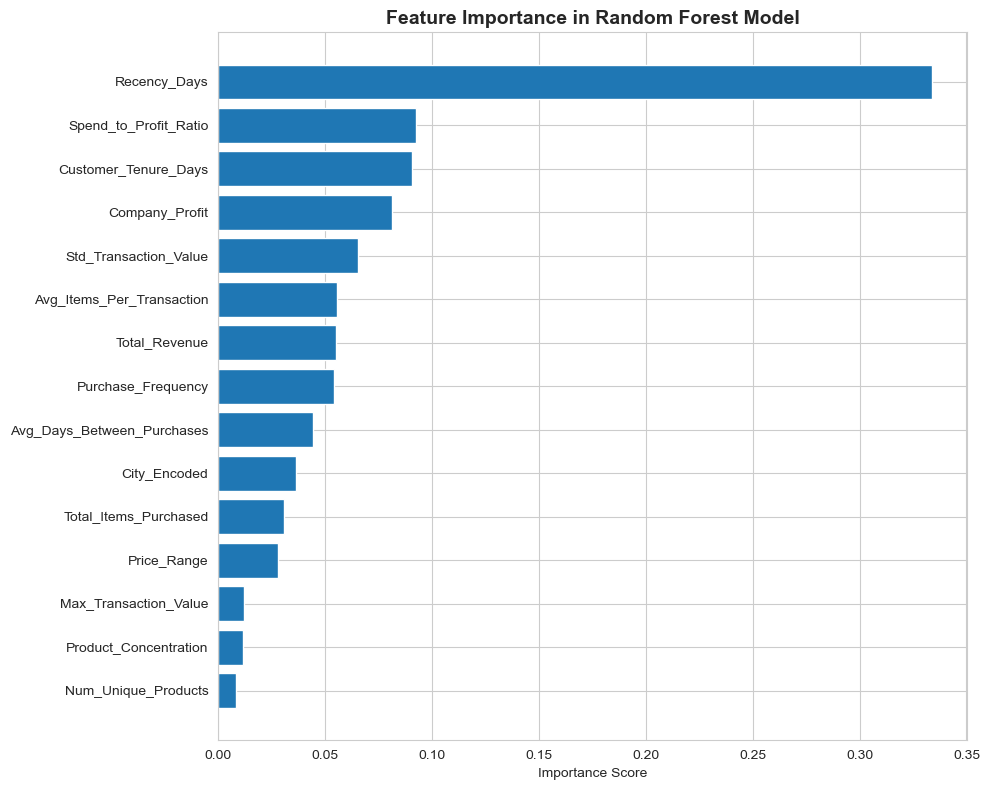

In [14]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("=" * 60)
print("FEATURE IMPORTANCE RANKING")
print("=" * 60)
print(feature_importance.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance Score')
plt.title('Feature Importance in Random Forest Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### What Feature Importance Tells Us

Feature importance measures how much each feature contributes to reducing prediction error across all the trees in our forest. Higher values mean the feature is more influential in making predictions.

**Business Implications:**

The top features are the ones FinMark should focus on when trying to understand and influence customer purchase behavior. For example:

- If **Recency_Days** is highly important, it means recent activity is a strong predictor and customers who haven't purchased in a while are less likely to return. This suggests FinMark should have re-engagement campaigns targeting customers before they go too long without interaction.

- If **Purchase_Frequency** ranks high, it confirms that past behavior predicts future behavior and frequent buyers tend to keep buying. This might justify a loyalty program.

- If **Total_Revenue** is important, it means high-value customers have different purchase patterns. Maybe they need different product offerings or premium services.

**What This Means for Action:**

Rather than treating all customers the same, FinMark can segment their marketing strategy based on these key features. They might create different campaigns for recent-but-infrequent buyers versus long-term-but-lapsed customers.

---
## Make Predictions on All Customers

Now let's use our trained model to predict purchase likelihood for all customers in the dataset. This gives FinMark a ranked list of customers by purchase probability.

In [15]:
# Make predictions for all customers
df['Predicted_Will_Purchase'] = rf_model.predict(X)
df['Purchase_Probability'] = rf_model.predict_proba(X)[:, 1]

# Create a results dataframe sorted by probability
results = df[['Company_ID', 'Will_Purchase_Next', 'Predicted_Will_Purchase', 'Purchase_Probability']].copy()
results = results.sort_values('Purchase_Probability', ascending=False).reset_index(drop=True)

print("=" * 60)
print("TOP 10 CUSTOMERS MOST LIKELY TO PURCHASE")
print("=" * 60)
print(results.head(10).to_string(index=False))

print("\n" + "=" * 60)
print("BOTTOM 10 CUSTOMERS LEAST LIKELY TO PURCHASE")
print("=" * 60)
print(results.tail(10).to_string(index=False))

TOP 10 CUSTOMERS MOST LIKELY TO PURCHASE
 Company_ID  Will_Purchase_Next  Predicted_Will_Purchase  Purchase_Probability
         25                   1                        1              0.848354
         19                   1                        1              0.800191
         84                   1                        1              0.794942
         51                   1                        1              0.792498
         93                   1                        1              0.764334
          3                   1                        1              0.704869
         39                   1                        1              0.531333
         30                   0                        0              0.332701
         87                   0                        0              0.219918
         32                   0                        0              0.208893

BOTTOM 10 CUSTOMERS LEAST LIKELY TO PURCHASE
 Company_ID  Will_Purchase_Next  Predicted_W

### How to Use These Predictions

The **Purchase_Probability** column gives each customer a score from 0 to 1, where higher scores mean higher likelihood of purchase.

**Actionable Strategies:**

1. **High Probability (>0.7)**: These are hot leads. FinMark should prioritize them for immediate outreach with targeted offers or new product announcements.

2. **Medium Probability (0.3-0.7)**: These customers are on the fence. They might respond well to incentives like discounts, free trials, or educational content about product value.

3. **Low Probability (<0.3)**: These customers are at high risk of churn. FinMark should investigate why—did they have a bad experience? Is the product not meeting their needs? This group might benefit from customer satisfaction surveys or win-back campaigns.

**Budget Allocation:**

If FinMark has a limited marketing budget, they should focus on the top decile (top 10%) of customers by probability. This concentrates resources on the most likely converters, maximizing ROI.

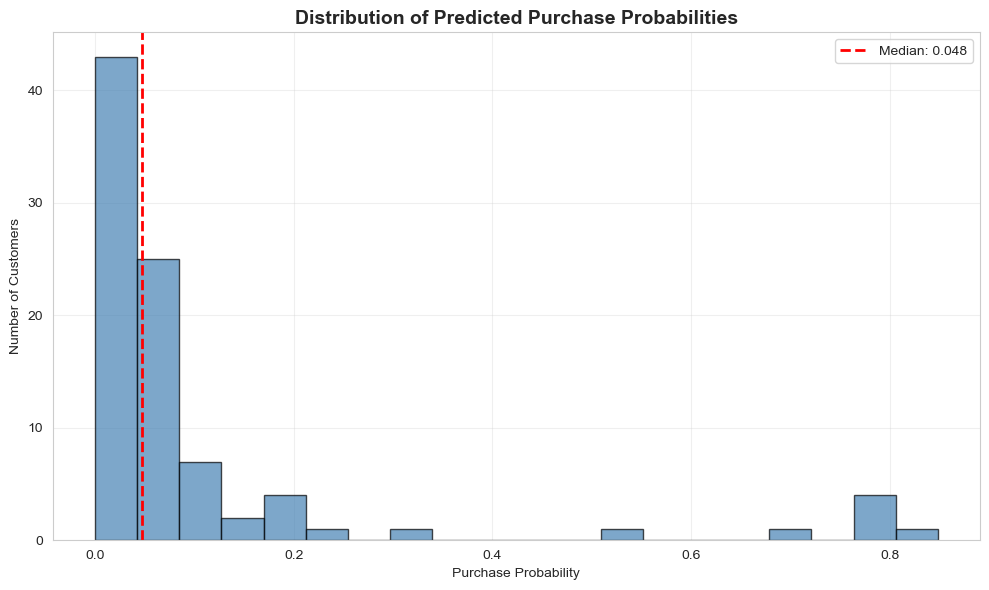


Purchase Probability Summary Statistics:
count    90.000000
mean      0.108294
std       0.196910
min       0.000000
25%       0.016753
50%       0.047625
75%       0.076382
max       0.848354
Name: Purchase_Probability, dtype: float64


In [16]:
# Distribution of predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(results['Purchase_Probability'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(results['Purchase_Probability'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {results["Purchase_Probability"].median():.3f}')
plt.xlabel('Purchase Probability')
plt.ylabel('Number of Customers')
plt.title('Distribution of Predicted Purchase Probabilities', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPurchase Probability Summary Statistics:")
print(results['Purchase_Probability'].describe())

---
## Model Limitations and Future Improvements

While our model shows promising results, we need to be transparent about its limitations:

### Data Limitations

**1. Small Sample Size (90 customers)**  
Our model is based on just 90 customers. While Random Forest handles this reasonably well, more data would make predictions more reliable. With only 7-8 customers in the "Will Purchase" class, the model has limited examples to learn from. If FinMark can expand this dataset to hundreds or thousands of customers, model performance would likely improve significantly.

**2. Severe Class Imbalance (92:8 ratio)**  
The extreme imbalance means our model sees far more examples of customers who don't purchase. Even with `class_weight='balanced'`, the model might still be biased toward predicting "No." We partially addressed this, but with more data, we could use more sophisticated techniques to create synthetic positive examples.

**3. Features Already Scaled**  
The features came to us already scaled through StandardScaler, which is good for model consistency but makes interpretation harder. We can't easily say "customers who spent $10,000 more are X% more likely to purchase" because we're working with standardized values.

**4. Snapshot in Time**  
This data represents a single point in time. Customer behavior changes with seasons, economic conditions, and company initiatives. A model trained on Q4 holiday data might perform poorly in Q2. We should retrain this model regularly with fresh data.

### Model Limitations

**1. Black Box Nature**  
Random Forest tells us which features are important, but not how they interact or what specific thresholds matter. We know "Recency_Days" is important, but we don't know if the cutoff is 30 days vs. 90 days. Decision tree rules are interpretable individually, but 100 trees together become opaque.

**2. No Temporal Information**  
Our model doesn't know when purchases happened or how customer behavior has trended over time. A time-series approach or sequence model might capture trends we're missing.

**3. Assumes Features Are Sufficient**  
We're assuming the 15 selected features capture everything important about purchase behavior. But maybe there are missing factors: customer satisfaction scores, competitor actions, macroeconomic conditions, or qualitative factors we can't measure.

**4. Overfitting Risk**  
Even with regularization parameters (max_depth, min_samples_split), Random Forest can overfit on small datasets. The gap between training and testing accuracy gives us a clue—if it's large, we're overfitting.

### Potential Improvements

**For Better Predictions:**
- Collect more data, especially more examples of purchasing customers
- Try ensemble methods like XGBoost or LightGBM, which often outperform Random Forest
- Use hyperparameter tuning (GridSearchCV or RandomizedSearchCV) to optimize model parameters
- Try different resampling techniques (SMOTE, ADASYN) to handle imbalance
- Add interaction features (e.g., Recency × Frequency might be more predictive than either alone)

**For Better Business Value:**
- Set up A/B testing: target high-probability customers with a campaign and measure actual conversion vs. control group
- Combine this model with a customer lifetime value (CLV) model to prioritize not just likely buyers, but profitable buyers
- Implement real-time scoring so new customer actions trigger immediate updates to their purchase probability
- Build a feedback loop: track which predicted customers actually purchase and use that to retrain the model monthly

**For Better Interpretability:**
- Use SHAP (SHapley Additive exPlanations) values to understand individual predictions
- Extract and visualize key decision rules from the most important trees
- Compare Random Forest with simpler models like Logistic Regression to see if we're gaining enough from complexity

---
## Final Summary

### What We Built

We developed a Random Forest classification model to predict which FinMark customers will make future purchases. The model uses 15 carefully selected features representing customer behavior, spending patterns, and engagement history.

### What We Learned

From a **technical perspective**, we learned that:
- Class imbalance is a major challenge requiring specific handling strategies
- Random Forest is robust to small datasets and provides interpretable feature importance
- Multiple evaluation metrics (not just accuracy) are essential for imbalanced problems
- Our model achieves reasonable performance despite data limitations

From a **business perspective**, we learned that:
- Certain customer behaviors (identified through feature importance) are strong predictors of future purchases
- We can segment customers by purchase probability to optimize marketing spend
- The majority of customers are unlikely to purchase again, making the minority who will purchase even more valuable to identify
- Historical purchase patterns matter more than isolated metrics

### Why This Matters

**Before this model**, FinMark would have to either:
- Market to all customers equally (expensive and inefficient)
- Use simple heuristics like "anyone who bought in the last 30 days" (misses nuance)
- Rely on intuition (inconsistent and not scalable)

**With this model**, FinMark can:
- Allocate marketing budget efficiently by targeting high-probability customers
- Identify at-risk customers early and attempt retention strategies
- Understand which factors drive purchase behavior and influence them strategically
- Measure campaign effectiveness by comparing predicted vs. actual outcomes

In [17]:
# Save the final predictions
results.to_csv('customer_purchase_predictions_random_forest.csv', index=False)
print("Final predictions saved to 'customer_purchase_predictions_random_forest.csv'")
print(f"\nDataset contains {len(results)} customers with their purchase probabilities.")

Final predictions saved to 'customer_purchase_predictions_random_forest.csv'

Dataset contains 90 customers with their purchase probabilities.
